In [5]:
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda
import time
from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1
import matplotlib.pyplot as plt


Image shape: (720, 720, 3)


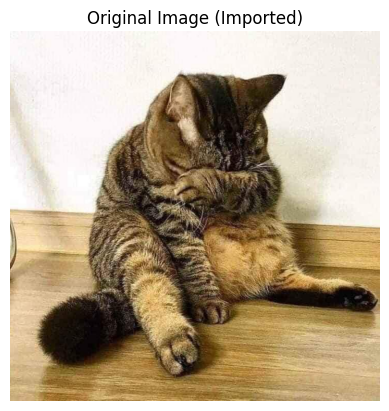

In [2]:
img = plt.imread("/content/drive/MyDrive/meme/15.jpg")
if img.dtype == np.uint8:
    img = img.astype(np.float32) / 255.0

h, w, c = img.shape
print("Image shape:", img.shape)

plt.imshow(img)
plt.title("Original Image (Imported)")
plt.axis("off")
plt.show()

Execution time (2D blocks): 1.377003 seconds


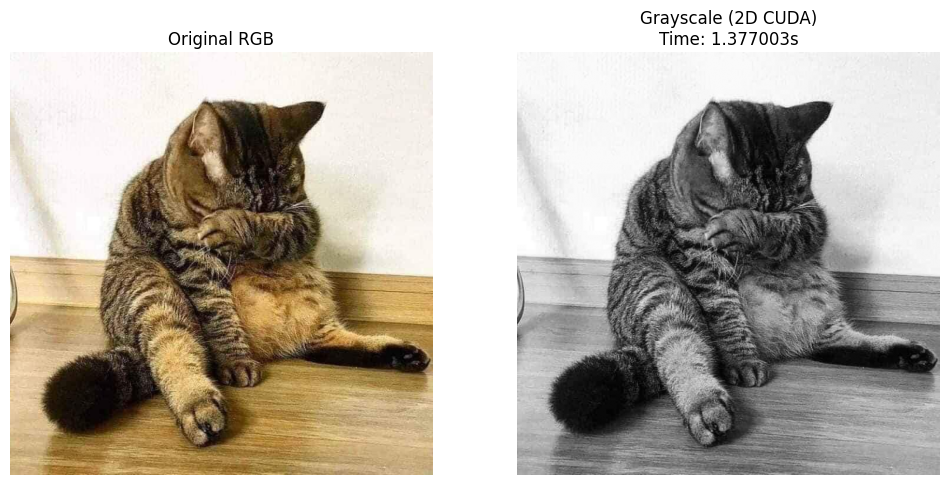

In [3]:
h, w, c = img.shape
img_u8 = (img * 255).astype(np.uint8)
d_src = cuda.to_device(img_u8)
d_gray = cuda.device_array((h, w), dtype=np.uint8)


@cuda.jit
def grayscale(src, dst):
    x, y = cuda.grid(2)
    if x < src.shape[0] and y < src.shape[1]:
        r = src[x, y, 0]
        g = src[x, y, 1]
        b = src[x, y, 2]
        dst[x, y] = (r + g + b) // 3


threadsperblock = (8, 8)
blockspergrid_x = (h + threadsperblock[0] - 1) // threadsperblock[0]
blockspergrid_y = (w + threadsperblock[1] - 1) // threadsperblock[1]
blockspergrid = (blockspergrid_x, blockspergrid_y)


start = time.time()
grayscale[blockspergrid, threadsperblock](d_src, d_gray)
cuda.synchronize()
end = time.time()

print(f"Execution time (2D blocks): {end - start:.6f} seconds")


gray_result = d_gray.copy_to_host()


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.imshow(img)
ax1.set_title("Original RGB")
ax1.axis("off")

ax2.imshow(gray_result, cmap='gray')
ax2.set_title(f"Grayscale (2D CUDA)\nTime: {end - start:.6f}s")
ax2.axis("off")

plt.show()


In [4]:
block_sizes = [(8, 8), (16, 16), (32, 32)]
results = []

for tp in block_sizes:
    threadsperblock = tp
    blockspergrid_x = (h + tp[0] - 1) // tp[0]
    blockspergrid_y = (w + tp[1] - 1) // tp[1]
    blockspergrid = (blockspergrid_x, blockspergrid_y)

    start = time.time()
    grayscale[blockspergrid, threadsperblock](d_src, d_gray)
    cuda.synchronize()
    end = time.time()

    exec_time = end - start
    results.append((tp, exec_time))



print(f"{'Threads per block':<20} | {'Execution Time (s)':>20}")
print("-" * 45)
for tp, t in results:
    print(f"{str(tp):<20} | {t:>20.6f}")


Threads per block    |   Execution Time (s)
---------------------------------------------
(8, 8)               |             0.000407
(16, 16)             |             0.000204
(32, 32)             |             0.000251


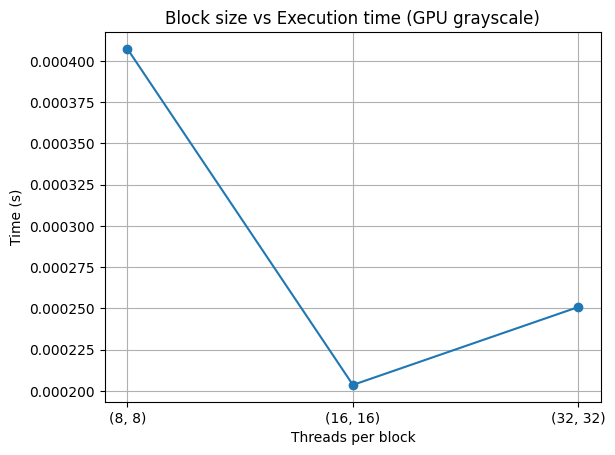

In [6]:
sizes = [f"{tp}" for tp, _ in results]
times = [t for _, t in results]

plt.plot(sizes, times, marker='o')
plt.title("Block size vs Execution time (GPU grayscale)")
plt.xlabel("Threads per block")
plt.ylabel("Time (s)")
plt.grid(True)
plt.savefig("blocksize_vs_time.png", dpi=150)
plt.show()
